In [1]:
import os
import wfdb
import scipy
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from tqdm import tqdm

In [2]:
def resample_sig(x, fs, fs_target):
    t = np.arange(x.shape[0]).astype("float64")

    if fs == fs_target:
        return x, t

    new_length = int(x.shape[0] * fs_target / fs)
    # Resample the array if NaN values are present
    if np.isnan(x).any():
        x = pd.Series(x.reshape((-1,))).interpolate().values
    resampled_x, resampled_t = scipy.signal.resample(x, num=new_length, t=t)
    assert (
        resampled_x.shape == resampled_t.shape
        and resampled_x.shape[0] == new_length
    )
    assert np.all(np.diff(resampled_t) > 0)

    return resampled_x, resampled_t

In [59]:
def preprocess(init_address, final_address, length=7500):
    files = [file[:-4] for file in os.listdir(init_address) if file.endswith('.dat')]

    classes = {'W': 0, '1': 1, '2': 2, '3': 3, '4': 3, 'R': 4}

    data = []
    for file in tqdm(files):
        signal = wfdb.rdrecord(init_address + file, channels=[0]).p_signal
        segments = wfdb.rdann(init_address + file, extension='st').sample
        stages = wfdb.rdann(init_address + file, extension='st').aux_note
        
        for idx, start in enumerate(segments):
            if start == 1:
                start = 0
            else:
                pass
            
            if stages[idx][0] != 'M':
                resampled_x, _ = resample_sig(signal[start:start+length, 0], 250, 100)
                data.append(np.append(resampled_x, classes[stages[idx][0]]))

    df = pd.DataFrame(np.array(data))
    df.to_csv(final_address)
    
    print(f"\nThe data has been saved in {final_address}.")
    
preprocess('../../Dataset/Sleep/', '../dataset/dataset.csv' ,length=7500)

100%|██████████| 18/18 [00:11<00:00,  1.62it/s]



The data has been saved in ../dataset/dataset.csv.


In [3]:
df = pd.read_csv('../dataset/dataset.csv')
df = df.drop(['Unnamed: 0'], axis=1)

labels = [int(i) for i in list(df['3000'])]

print(f"Number od signals with the label 0 is: {labels.count(0)}")
print(f"Number od signals with the label 1 is: {labels.count(1)}")
print(f"Number od signals with the label 2 is: {labels.count(2)}")
print(f"Number od signals with the label 3 is: {labels.count(3)}")
print(f"Number od signals with the label 4 is: {labels.count(4)}")

Number od signals with the label 0 is: 3115
Number od signals with the label 1 is: 1815
Number od signals with the label 2 is: 3887
Number od signals with the label 3 is: 664
Number od signals with the label 4 is: 700


In [7]:
df.shape

(10181, 3001)

In [6]:
train = df.iloc[:int(len(df) * 0.8), :]

In [6]:
train.shape

(8144, 3001)

In [11]:
np.array(train.iloc[0][:3000])

array([0.0711013 , 0.14623332, 0.3313848 , ..., 0.04879917, 0.04797405,
       0.06416583])

In [29]:
from ssqueezepy import ssq_stft

Twxo, TF, *_ = ssq_stft(np.array(train.iloc[0][:512]))

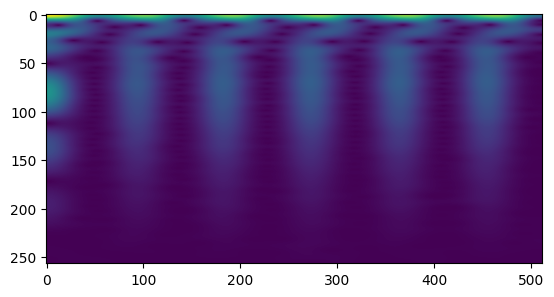

In [30]:
plt.imshow(np.abs(TF))

In [31]:
np.abs(TF).min()

9.6721575e-05

In [4]:
import os

os.chdir('../')

In [7]:
from dataloader.dataloader import DataGenerator

my_generator = DataGenerator(data=train, 
                             image_shape=(256, 512, 1), 
                             signal_shape=(3000, 1), 
                             batch_size=4, 
                             cls_num=5, 
                             width=512, 
                             overlap=17)

In [9]:
a = next(iter(my_generator))

In [16]:
print(a[0][0][0].shape)
print(a[0][0][0].max())
print(a[0][0][0].min())

(6, 256, 512, 1)
1.0
0.0


In [17]:
print(a[0][1][0].shape)
print(a[0][1][0].max())
print(a[0][1][0].min())

(3000, 1)
1.0
0.0


In [19]:
print(a[1])

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


In [1]:
import os

os.chdir('../')

In [2]:
from model.model import build

model = build(image_shape=(6, 256, 512, 1), 
              signal_shape=(3000, 1), 
              num_classes=5, 
              lnn_units=[512, 128], 
              fin_path='checkpoints/fin_20240810_050955', 
              kan_units=[32])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 256, 512  0           []                               
                                , 1)]                                                             
                                                                                                  
 time_distributed (TimeDistribu  (None, 6, 64, 128,   0          ['input_1[0][0]']                
 ted)                           1)                                                                
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 6, 64, 128,   80         ['time_distributed[0][0]']       
 buted)                         8)                                                          

In [ ]:
CFG_stage = {
    "shape": (128, 128, 2),
    "batch_size": 32,
    "cls_num": 5,
    "num_epochs": 100,
    "learning_rate": 0.001,
    "loss": "categorical_crossentropy",
    "optimizer": 'adam',
    "monitor": "val_loss",
    "mode": "min",
    "label_smoothing": 0.0,
    "metrics": ['accuracy']
}